In [1]:
%matplotlib inline
import numpy
import numpy as np
from matplotlib import pyplot
from amuse.units import (units, constants)
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import orbital_elements_from_binary
from amuse.lab import Particles
def orbital_period(Mtot, a):
    return (((4 * numpy.pi**2) * a**3)/(constants.G * Mtot)).sqrt()

SMBH = Particles(1)
SMBH.name = "SMBH"
SMBH.mass = 4.154e+6 | units.MSun
SMBH.position = (0, 0, 0) | units.pc
SMBH.velocity = (0, 0, 0) | units.kms

In [2]:
def random_v(x, y, z):
    vx = np.zeros(3)
    vy = np.zeros(3)
    vz = np.zeros(3)
    vx[0] = np.random.rand()*2-1
    vy[0] = np.random.rand()*2-1
    vz[0] = -(vx[0]*x+vy[0]*y)/z
    
    vx[0] = np.random.rand()*2-1
    vz[0] = np.random.rand()*2-1
    vy[0] = -(vx[0]*x+vz[0]*z)/y
    
    vz[0] = np.random.rand()*2-1
    vy[0] = np.random.rand()*2-1
    vx[0] = -(vz[0]*z+vy[0]*y)/x
    
    vx = vx.sum()
    vy = vy.sum()
    vz = vz.sum()
    vtotal = np.sqrt(vx**2+vy**2+vz**2)
    
    return vx/vtotal, vy/vtotal, vz/vtotal

def relative_orbital_velocity(distance, mass=SMBH.mass):
    return (constants.G*mass/distance).sqrt()

def plot(body):
    scatter(body.x.value_in(units.pc), body.z.value_in(units.pc), s=20, alpha=0.5)
    #scatter(SMBH.x.value_in(units.pc), SMBH.z.value_in(units.pc), s=80, c='r')
    pyplot.xlim(-10, 10)
    pyplot.ylim(-10, 10)
#     pyplot.colorbar()
#     pyplot.show()

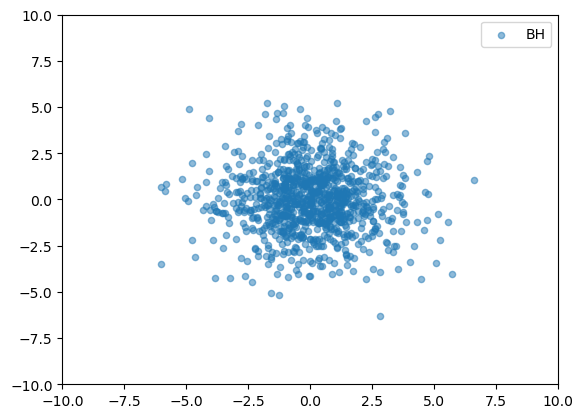

In [3]:
N = 1000
n_BHs = N
alpha_IMF = -2.35

from amuse.lab import new_powerlaw_mass_distribution
m_BHs = new_powerlaw_mass_distribution(n_BHs, 
                                         1.0|units.MSun, 
                                         100.0|units.MSun, 
                                         alpha_IMF)

r_cluster = 3 | units.parsec
from amuse.units import nbody_system
converter=nbody_system.nbody_to_si(m_BHs.sum(),r_cluster)
from amuse.ic.kingmodel import new_king_model
W0 = 3.0
bodies=new_king_model(n_BHs, W0, convert_nbody=converter)
bodies.mass = m_BHs
bodies.name = "BH"
for i in range(0, N):
    x, y, z = bodies[i].x.value_in(units.km), bodies[i].y.value_in(units.km), bodies[i].z.value_in(units.km)
    distance = np.sqrt(x**2+y**2+z**2) | units.km
    vorb = relative_orbital_velocity(distance, mass=SMBH.mass)
    bodies[i].vx, bodies[i].vy, bodies[i].vz = vorb*random_v(x, y, z)
bodies.scale_to_standard(converter)
from amuse.plot import scatter

plot(bodies)
pyplot.legend([bodies[0].name], loc="best")

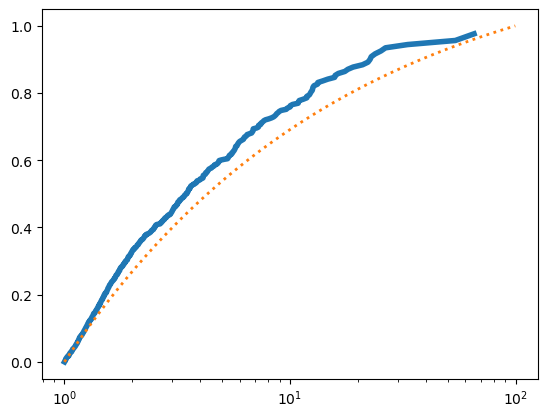

In [4]:
def plot_cdf(m, alpha_IMF=-2.35):
    m = sorted(m.value_in(units.MSun))
    fm = numpy.array([0])
    for mi in m:
        fm = numpy.append(fm, fm[-1] + mi)
    fm /= max(fm)
    from amuse.plot import plot
    pyplot.plot(m, fm[:len(m)], lw=4, ls="-")
    x = 10**numpy.arange(0, 2.0, 1./len(m))
    y = x**(alpha_IMF+2)
    fy = numpy.array([0])
    for yi in y:
        fy = numpy.append(fy, fy[-1] + yi)    
    fy /= max(fy)
    pyplot.plot(x, fy[:len(x)], lw=2, ls=":")
    pyplot.semilogx()
    pyplot.show()
plot_cdf(m_BHs)

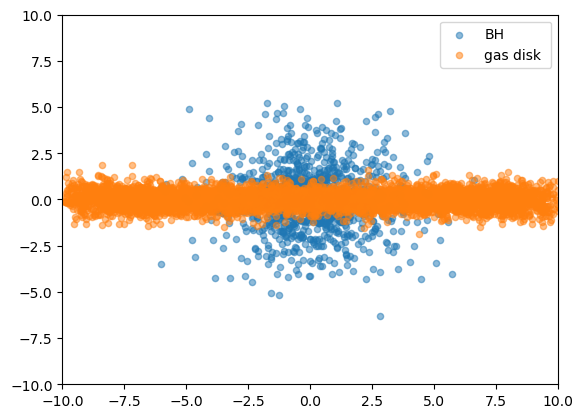

In [5]:
from amuse.ext.protodisk import ProtoPlanetaryDisk
from amuse.lab import nbody_system

def make_disk_around_SMBH(SMBH):
    R = 10|units.pc
    Ndisk = 10000
    Rin = 0.1
    Rout = 1
    Pinner = orbital_period(SMBH.mass, Rin*R)
    Mdisk = 1e-2 * SMBH.mass
    converter1 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    
    disk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter1,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=Mdisk/SMBH.mass).result
    disk.name = "gas disk "
    disk.move_to_center()
    masses = Mdisk/float(Ndisk)
    disk.mass = masses
    rho = 3.0| (units.g/units.cm**3)
    disk.radius = (disk.mass/(4*rho))**(1./3.)
    return disk, Pinner, converter1

disk, Pinner, converter1 = make_disk_around_SMBH(SMBH)
from amuse.plot import scatter

plot(bodies)
plot(disk)
pyplot.legend([bodies[0].name, disk[0].name], loc="best")
bodies.add_particles(SMBH)

In [6]:
from amuse.community.huayno.interface import Huayno
from amuse.community.fi.interface import Fi
gravity = Huayno(converter1, workers=8)
gravity.particles.add_particles(bodies-SMBH)
channel = {"from BHs": bodies.new_channel_to(gravity.particles),
            "to_BHs": gravity.particles.new_channel_to(bodies)}

hydro = Fi(converter1, mode="openmp", workers=8)
hydro.parameters.use_hydro_flag = True
hydro.parameters.radiation_flag = False
hydro.parameters.gamma = 1
hydro.parameters.isothermal_flag = True
hydro.parameters.integrate_entropy_flag = False
hydro.parameters.timestep = 1*Pinner 
hydro.parameters.verbosity = 0
hydro.parameters.eps_is_h_flag = False    # h_smooth is constant
eps = 0.01 | units.pc
hydro.parameters.gas_epsilon = eps
hydro.parameters.sph_h_const = eps

hydro.particles.add_particles(disk)
hydro.dm_particles.add_particles(SMBH.as_set())
channel.update({"from_disk": disk.new_channel_to(hydro.particles)})
channel.update({"to_disk": hydro.particles.new_channel_to(disk)})
channel.update({"from_smbh": SMBH.new_channel_to(hydro.dm_particles)})
channel.update({"to_smbh": hydro.dm_particles.new_channel_to(SMBH)})

bodies.add_particles(disk)

In [7]:
from amuse.couple import bridge
from amuse.ext.composition_methods import *
gravhydro = bridge.Bridge(use_threading=False) #, method=SPLIT_4TH_S_M4)
gravhydro.add_system(gravity, (hydro,))
gravhydro.add_system(hydro, (gravity,))
gravhydro.timestep = 1*Pinner
print(Pinner.value_in(units.yr))

[ 45958.60946772]


cluster at Time= [45958609.4677] yr Mass= 4198278.28625 MSun
cluster at Time= [91917218.9354] yr Mass= 4198278.28625 MSun
cluster at Time= [137875828.403] yr Mass= 4198278.28625 MSun
cluster at Time= [183834437.871] yr Mass= 4198278.28625 MSun
cluster at Time= [229793047.339] yr Mass= 4198278.28625 MSun
cluster at Time= [275751656.806] yr Mass= 4198278.28625 MSun
cluster at Time= [321710266.274] yr Mass= 4198278.28625 MSun
cluster at Time= [367668875.742] yr Mass= 4198278.28625 MSun
cluster at Time= [413627485.209] yr Mass= 4198278.28625 MSun
cluster at Time= [459586094.677] yr Mass= 4198278.28625 MSun
cluster at Time= [505544704.145] yr Mass= 4198278.28625 MSun
cluster at Time= [551503313.613] yr Mass= 4198278.28625 MSun
cluster at Time= [597461923.08] yr Mass= 4198278.28625 MSun
cluster at Time= [643420532.548] yr Mass= 4198278.28625 MSun
cluster at Time= [689379142.016] yr Mass= 4198278.28625 MSun
cluster at Time= [735337751.484] yr Mass= 4198278.28625 MSun
cluster at Time= [7812963

KeyboardInterrupt: 

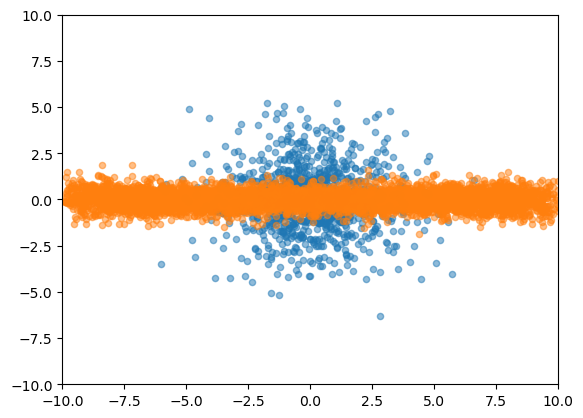

In [8]:
plot(bodies-disk-SMBH)
plot(disk)

from amuse.ext.composition_methods import *
from amuse.ext.orbital_elements import orbital_elements_from_binary

def gravity_hydro_bridge(gravity, hydro, gravhydro, bodies,
                         t_end):

    gravity_initial_total_energy = gravity.get_total_energy() + hydro.get_total_energy()
    model_time = 0 | units.Myr
    dt = 1000.0*Pinner
    x=1
    while model_time < t_end:

        model_time += dt

#         orbit_planet = orbital_elements_from_binary(bodies[:2], G=constants.G)
#         orbit_moon = orbital_elements_from_binary(bodies[1:3], G=constants.G)
#         print("Planet:", "ae=", orbit_planet[2].in_(units.AU), orbit_planet[3])
#         print("Moon:", "ae=", orbit_moon[2].in_(units.AU), orbit_moon[3])
        
#         dE_gravity = gravity_initial_total_energy/(gravity.get_total_energy()+hydro.get_total_energy())
#         print("Time:", model_time.in_(units.day), \
#               "dE=", dE_gravity)#, dE_hydro
        if model_time.value_in(units.yr)>(x*Pinner.value_in(units.yr)):
            x+=100
            print("cluster at Time=", model_time.in_(units.yr), 
                    "Mass=", bodies.mass.sum().in_(units.MSun))
        b = (bodies-SMBH-disk).get_binaries(hardness=10)
        if(len(b)>0):
            print("Number of binaries found:", len(b))
            print("binary:", b)
            if(len(b)==5):
                gravity.stop()
                hydro.stop()

        gravhydro.evolve_model(model_time)
        channel["to_BHs"].copy()
        channel["to_disk"].copy()
        channel["to_smbh"].copy()
        
#         print("S=", bodies[:3])
#         print("g=", gravity.particles)
#         print(gravity.particles.y.in_(units.pc), moon.y.in_(units.pc))

    gravity.stop()
    hydro.stop()

t_end = 1e6*Pinner
gravity_hydro_bridge(gravity, hydro, gravhydro, 
                     bodies, t_end)
plot(bodies-disk-SMBH)
plot(disk)
pyplot.legend([bodies[0].name+"_1", disk[0].name+"_1", bodies[0].name+"_2", disk[0].name+"_2"], loc="best")

In [ ]:
plot(bodies-disk-SMBH)
plot(disk)
pyplot.legend([bodies[0].name, disk[0].name], loc="best")

In [ ]:
#print(bodies.name)